In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import wilcoxon

sns.set_style("whitegrid")

In [2]:
def subsample(array, n):
    np.random.seed(15)
    idx = np.random.randint(len(array), size=n)
    return array[idx,:]

## Entropy - compare shannon entropy between wildtype and mutants, use the controls to calculate the efficiency of methylation per base

In [3]:
load_dir =  "ARS305"

In [10]:
#feature annotation

#ARS305_anno = pd.read_csv("ARS305/Features_from ARS305_end_LexA _(31 .. 1124).txt", sep  = "\t", 
#                          header = None, index_col = 0)
#ARS305_anno.columns = ["position", "length"]

#ARS305_anno = pd.read_csv("ARS305/coordinates_ARS305.txt", sep  = "\t", 
#                          header = None, index_col = 0)

ARS305_anno = pd.read_csv(load_dir + "/ARS305_80bp.txt", sep  = "\t", 
                          header = None, index_col = 0)
ARS305_anno.columns = ["position"]

ARS305_anno.index = ARS305_anno.index.astype("string")
ARS305_anno.index = ARS305_anno.index.str.strip()

ARS305_anno["pos_start"] = ARS305_anno.position.str.split("-").str[0].astype(int) -1
ARS305_anno["pos_stop"] = ARS305_anno.position.str.split("-").str[1].astype(int) -1

ARS305_anno["length"] = ARS305_anno.pos_stop - ARS305_anno.pos_start

#forward strand
ARS305_wt_rep3 = np.loadtxt("ARS305/wt_mat_Megalodon_repIII_ARS305_end_LexA.txt")
ARS305_wt_rep2 = np.genfromtxt("ARS305/ARS305_wt_REP2_noNA.csv", dtype = int, delimiter = ",") #715 reads
ARS305_dies6_rep1 = np.loadtxt("ARS305/DIES6_ALL_REP1_ARS305_end_LexA.txt")
ARS305_dies6_rep2 = np.genfromtxt("ARS305/DIES6_ARS305_REP2_780READS.csv", dtype = int, delimiter = ",")

ARS305_disw2_rep1 = np.genfromtxt("ARS305/ARS305_disw2_rep1_780READS_noNA.csv", dtype = int,
                                 delimiter = ",")
ARS305_disw2_rep2 = np.genfromtxt("ARS305/ARS305_disw2_rep2_780READS_noNA.csv", dtype = int, delimiter = ",")

#reverse strand
wt_rep3_rev = np.loadtxt( load_dir + "/wt_repIII_ARS305_end_LexA_rev.txt") #780 reads
wt_rep2_rev = np.loadtxt( load_dir + "/wt_repII_ARS305_rev.txt") #780 reads

dies6_rep1_rev = np.loadtxt(load_dir + "/DIES6_ALL_REP1_ARS305_rev.txt") #780 reads
dies6_rep2_rev = np.loadtxt(load_dir + "/DIES6_ALLstrains_meth_REP2_ARS305_rev.txt") #780 reds

disw2_rep1_rev = np.loadtxt(load_dir + "/REP1_disw2_ARS305_rev.txt") 
disw2_rep2_rev = np.loadtxt(load_dir + "/disw2_all_meth_REP2_ARS305_rev.txt") #780 reads

#join data for the strands
wt_rep3_join = np.concatenate((ARS305_wt_rep3[:, 1:], wt_rep3_rev), axis = 0)
wt_rep2_rev_sub = subsample(wt_rep2_rev, 715)
wt_rep2_join = np.concatenate((ARS305_wt_rep2[:, 1:], wt_rep2_rev_sub), axis = 0)

dies6_rep1_join = np.concatenate((ARS305_dies6_rep1[:, 1:], dies6_rep1_rev), axis = 0)
dies6_rep2_join = np.concatenate((ARS305_dies6_rep2[:, 1:], dies6_rep2_rev), axis = 0)

disw2_rep1_join = np.concatenate((ARS305_disw2_rep1[:, 1:], disw2_rep1_rev), axis = 0)
disw2_rep2_join = np.concatenate((ARS305_disw2_rep2[:, 1:], disw2_rep2_rev), axis = 0)

In [11]:
# load data for plasmid spike-ins
wt_rep3_naked_plasmid = np.loadtxt("controls/wt_mat_Megalodon_repIII_naked_plasmid.txt")
wt_rep2_naked_plasmid = np.loadtxt("controls/naked_plasmid_wt_rep2_1000reads.txt") #1000 reads

#np.random.seed(0)
wt_rep2_naked_plasmid_sub = subsample(wt_rep2_naked_plasmid, 780)
wt_rep2_naked_plasmid = wt_rep2_naked_plasmid_sub

dies6_rep1_naked = np.loadtxt("controls/DIES6_ALL_REP1_naked_plasmid.txt")
dies6_rep2_naked = np.loadtxt("controls/DIES6_rep2_780READS_naked_plasmid.txt")

disw2_rep1_naked = np.loadtxt("controls/naked_plasmid_disw2_rep1_clean_780READS.csv")
disw2_rep2_naked = np.loadtxt("controls/naked_plasmid_disw2_rep2_clean_780_reads.csv")

#Load methylation data for the reverse strand:

wt_rep3_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_repIII_naked_plasmid.txt")
wt_rep2_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_repII_naked_plasmid.txt")

dies6_rep1_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_20220126_METHYLATION_DIES6_ALL_REP1_naked_plasmid.txt")
dies6_rep2_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_20220207_DIES6_ALLstrains_meth_REP2_naked_plasmid.txt")

disw2_rep1_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_20211201_all_strains_REP1_disw2_naked_plasmid.txt")
disw2_rep2_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_20220221_disw2_all_meth_REP2_naked_plasmid.txt")

wt_rep3_plasmid_join = np.concatenate((wt_rep3_naked_plasmid, wt_rep3_plasmid_rev[:, :-1]), axis = 0)
wt_rep2_plasmid_join = np.concatenate((wt_rep2_naked_plasmid, wt_rep2_plasmid_rev[:, :-1]), axis = 0)

dies6_rep1_plasmid_join = np.concatenate((dies6_rep1_naked, dies6_rep1_plasmid_rev[:, :-1]), axis = 0)
dies6_rep2_plasmid_join = np.concatenate((dies6_rep2_naked, dies6_rep2_plasmid_rev[:, :-1]), axis = 0)

disw2_rep1_plasmid_join = np.concatenate((disw2_rep1_naked, disw2_rep1_plasmid_rev[:, :-1]), axis = 0)
disw2_rep2_plasmid_join = np.concatenate((disw2_rep2_naked, disw2_rep2_plasmid_rev[:, :-1]), axis = 0)

In [13]:
overlap_plasmid_wt3 = wt_rep3_naked_plasmid[:, 4081:4791]
overlap_plasmid_wt2 = wt_rep2_naked_plasmid[:, 4081:4791]

overlap_plasmid_dies6_1 = dies6_rep1_naked[:, 4081:4791]
overlap_plasmid_dies6_2 = dies6_rep2_naked[:, 4081:4791]

overlap_plasmid_disw2_1 = disw2_rep1_naked[:, 4081:4791]
overlap_plasmid_disw2_2 = disw2_rep2_naked[:, 4081:4791]

overlap_ARS305_wt3 = ARS305_wt_rep3[:, 223:933]
overlap_ARS305_wt2 = ARS305_wt_rep2[:, 223:933]

overlap_ARS305_dies6_1 = ARS305_dies6_rep1[:, 223:933]
overlap_ARS305_dies6_2 = ARS305_dies6_rep2[:, 223:933]
overlap_ARS305_disw2_1 = ARS305_disw2_rep1[:, 223:933]
overlap_ARS305_disw2_2 = ARS305_disw2_rep2[:, 223:933]

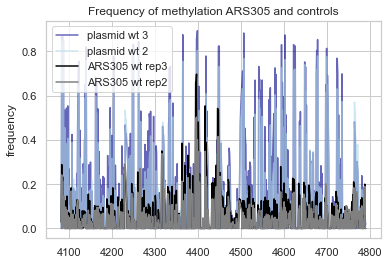

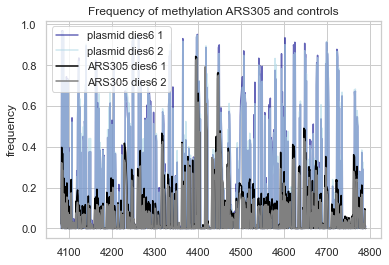

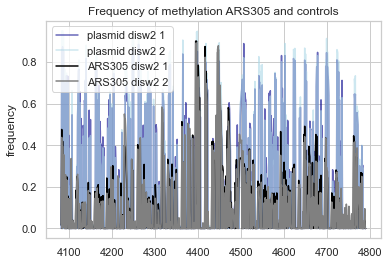

In [14]:
N=1

sns.set(font_scale=1)
sns.set_style("whitegrid")

sns.lineplot(x = range(4081,4791), 
             y = np.convolve(overlap_plasmid_wt3.mean(axis=0),
                             np.ones(N)/N, mode ="same"), 
             color = "darkblue", label = "plasmid wt 3", alpha = 0.6)
sns.lineplot(x = range(4081,4791), 
             y = np.convolve(overlap_plasmid_wt2.mean(axis=0),
                             np.ones(N)/N, mode ="same"), 
             color = "lightblue", label = "plasmid wt 2", alpha = 0.6)
sns.lineplot(x = range(4081,4791), 
             y = np.convolve(overlap_ARS305_wt3.mean(axis=0), 
                             np.ones(N)/N, mode ="same"), 
             color = "black", label = "ARS305 wt rep3")
sns.lineplot(x = range(4081,4791), 
             y = np.convolve(overlap_ARS305_wt2.mean(axis=0), 
                             np.ones(N)/N, mode ="same"), 
             color = "grey", label = "ARS305 wt rep2")
plt.ylabel("frequency")
plt.title("Frequency of methylation ARS305 and controls")
#plt.savefig(load_dir + "/plots/methyl_efficiency_wt.tif", dpi=300)
plt.show()

#show efficiency for dies6
sns.lineplot(x = range(4081,4791), 
             y = np.convolve(overlap_plasmid_dies6_1.mean(axis=0),
                             np.ones(N)/N, mode ="same"), 
             color = "darkblue", label = "plasmid dies6 1", alpha = 0.6)
sns.lineplot(x = range(4081,4791), 
             y = np.convolve(overlap_plasmid_dies6_2.mean(axis=0),
                             np.ones(N)/N, mode ="same"), 
             color = "lightblue", label = "plasmid dies6 2", alpha = 0.6)
sns.lineplot(x = range(4081,4791), 
             y = np.convolve(overlap_ARS305_dies6_1.mean(axis=0), 
                             np.ones(N)/N, mode ="same"), 
             color = "black", label = "ARS305 dies6 1")
sns.lineplot(x = range(4081,4791), 
             y = np.convolve(overlap_ARS305_dies6_2.mean(axis=0), 
                             np.ones(N)/N, mode ="same"), 
             color = "grey", label = "ARS305 dies6 2")
plt.ylabel("frequency")
plt.title("Frequency of methylation ARS305 and controls")
#plt.savefig(load_dir + "/plots/methyl_efficiency_dies6.tif", dpi=300)
plt.show()

#show efficiency for disw2
sns.lineplot(x = range(4081,4791), 
             y = np.convolve(overlap_plasmid_disw2_1.mean(axis=0),
                             np.ones(N)/N, mode ="same"), 
             color = "darkblue", label = "plasmid disw2 1", alpha = 0.6)
sns.lineplot(x = range(4081,4791), 
             y = np.convolve(overlap_plasmid_disw2_2.mean(axis=0),
                             np.ones(N)/N, mode ="same"), 
             color = "lightblue", label = "plasmid disw2 2", alpha = 0.6)
sns.lineplot(x = range(4081,4791), 
             y = np.convolve(overlap_ARS305_disw2_1.mean(axis=0), 
                             np.ones(N)/N, mode ="same"), 
             color = "black", label = "ARS305 disw2 1")
sns.lineplot(x = range(4081,4791), 
             y = np.convolve(overlap_ARS305_disw2_2.mean(axis=0), 
                             np.ones(N)/N, mode ="same"), 
             color = "grey", label = "ARS305 disw2 2")
plt.ylabel("frequency")
plt.title("Frequency of methylation ARS305 and controls")
#plt.savefig(load_dir + "/plots/methyl_efficiency_disw2.tif", dpi=300)
plt.show()

In [15]:
overlap_plasmid_disw2_1.mean(axis=0).min() #0.0
(overlap_plasmid_disw2_1.mean(axis=0) == 0).sum() #360
(overlap_plasmid_disw2_2.mean(axis=0) == 0).sum() #356

356

In [23]:
## Normalise origin data to nucleosomal data
#normalisation to the mean methylation freq of the spike in of nucleosomal arrays
"""
mean_array_wt_rep3 = 0.047172
mean_array_wt_rep2 = 0.034160
mean_array_dies6_rep1 = 0.050732
mean_array_dies6_rep2 = 0.045048
mean_array_disw2_rep1 = 0.061350
mean_array_disw2_rep2 = 0.059359

wt_rep3_mean_norm = ARS305_wt_rep3.mean(axis = 0)/mean_array_wt_rep3
wt_rep2_mean_norm = ARS305_wt_rep2.mean(axis = 0)/mean_array_wt_rep2

pooled_wt = np.concatenate((wt_rep3_mean_norm.reshape(1, -1), wt_rep2_mean_norm.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_mean_norm = ARS305_dies6_rep1.mean(axis = 0)/mean_array_dies6_rep1
dies6_rep2_mean_norm = ARS305_dies6_rep2.mean(axis = 0)/mean_array_dies6_rep2

pooled_dies6 = np.concatenate((dies6_rep1_mean_norm.reshape(1, -1), dies6_rep2_mean_norm.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_mean_norm = ARS305_disw2_rep1.mean(axis = 0)/mean_array_disw2_rep1
disw2_rep2_mean_norm = ARS305_disw2_rep2.mean(axis = 0)/mean_array_disw2_rep2

pooled_disw2 = np.concatenate((disw2_rep1_mean_norm.reshape(1, -1), disw2_rep2_mean_norm.reshape(1,-1)), axis = 0).mean(axis = 0)

"""

## Test whether the efficiency is sequence dependent for the plasmid samples

In [17]:
seq = "gacagaccacttatgacagtatttcaggccgctcttataaaatgacatgttaacaaacagttctgattattcgccttttgacaggacgataatgtaaatagttgtggtagtatcattcaggtatgtaactgtttactttgtatcgcttgaaaaaaataagcatttcagagccttctttggagctcaagtggattgaggccacagcaagaccggccagtttgaatgctcaactcttcaaaagaaattcctcaaatatgtccagtttcatgtactgtccggtgtgatttattattttttatttactttgtagttcttaaagctaagatttttttctttgataaattcttgttttcatatcctaaaattaaagggaaaataaacaatacataacaaaacatataaaaaccaacacaataaaaaaaaggatcaaatactcattaaagtaacttacacgggggctaaaaacggagtttgatgaatattcacaagataaaaatcatatgtatgtttctgatatatcgatatacaatcaaacactttcaagaatttgtttgtagactttttgctagagacctcatcaaagtgctaccaactaagatcaacttatacttcttttagagaaaatttttttcaatgtactccaaagagatttagatcctgtctcttcctcttcctcttcctcgaaagtcaaagaaaaatcagagtctccc"

eff_df = pd.DataFrame({"wt_rep3": overlap_plasmid_wt3.mean(axis=0)}, index=range(4081, 4791))


eff_df["base"] = [letter for letter in seq]
eff_df["wt_rep2"] = overlap_plasmid_wt2.mean(axis=0)
eff_df["dies6_rep1"] = overlap_plasmid_dies6_1.mean(axis=0)
eff_df["dies6_rep2"] = overlap_plasmid_dies6_2.mean(axis=0)
eff_df["disw2_rep1"] = overlap_plasmid_disw2_1.mean(axis=0)
eff_df["disw2_rep2"] = overlap_plasmid_disw2_2.mean(axis=0)

eff_df_melt = eff_df.melt(id_vars="base", var_name= "sample", value_name="efficiency")

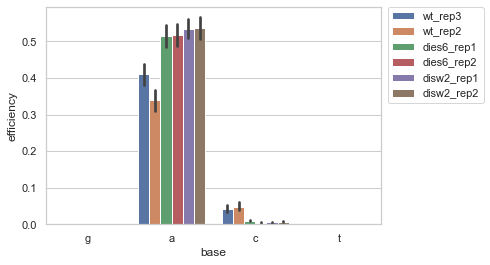

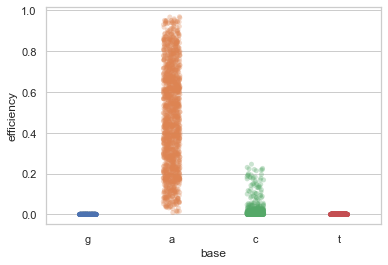

In [18]:
sns.barplot(data = eff_df_melt, x = "base", y = "efficiency", hue = "sample")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.show()

sns.stripplot(data = eff_df_melt, x = "base", y = "efficiency", alpha=0.3)#, hue = "sample")#, inner="points")
#plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.show()

In [25]:
pooled_wt.shape

(1084,)

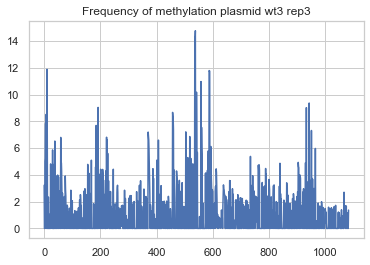

Text(0.5, 0, 'frequency')

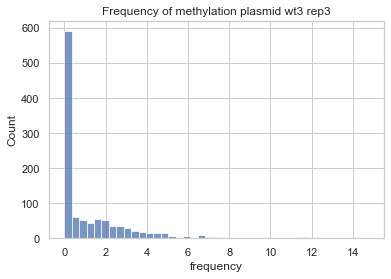

In [26]:
sns.lineplot(x = range(1084), y = pooled_wt)
plt.title("Frequency of methylation plasmid wt3 rep3")
plt.show()

sns.histplot(pooled_wt)
plt.title("Frequency of methylation plasmid wt3 rep3")
plt.xlabel("frequency")

In [40]:
#define the the efficiency of methylation per base E(x) as the average methylation in top 3% methylated region of the nucleosomal array
#This was calculated in a the notebook looking at controls
#then, the probabilitity P of a genomic position x being nucleosome-free is:
#P(x) = f(x) + (1-f(x))(1-E(X)) , with f(x) being the frequency of methylation at a genomic position x

prob_wt3 = ARS305_wt_rep3.mean(axis=0) + (1- ARS305_wt_rep3.mean(axis=0))*(1-0.306997)
prob_dies61 = ARS305_dies6_rep1.mean(axis=0) + (1- ARS305_dies6_rep1.mean(axis=0))*(1-0.259767)

prob_wt3.min(), prob_wt3.max(), prob_dies61.min(), prob_dies61.max()

(0.693003, 0.9071137282051283, 0.7402329999999999, 0.9593697769230769)

Text(0.5, 1.0, 'probability of being nucleosome free, ARS305 wt rep3')

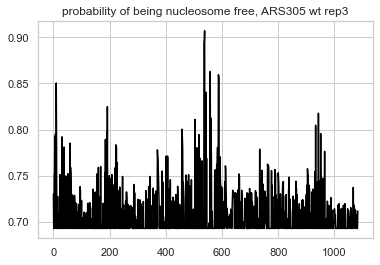

In [33]:
sns.lineplot(x = range(1084), 
             y = prob_wt3, color = "black")
plt.title("probability of being nucleosome free, ARS305 wt rep3")

In [34]:
#If we use the effiency of methylation to correct for unseen ones, in ~50 % of the positions, 
#the probability of being nucleosome free is 1. 
#The efficiency of the methylation reaction seems to be a aproblem here.

#If we leave out this correction, the probability of neucleosome-free is between 0 und 0.69.

0

In [35]:
#Entropy for position x is then:
#S = -(P*logP + (1-P)*log(1-P))

def shannon_entropy(P):
    return -(P*np.log(P) - (1-P)*np.log(1-P))

array([-0.12378118, -0.10839935, -0.10839935, ..., -0.10839935,
       -0.10839935, -0.11660703])

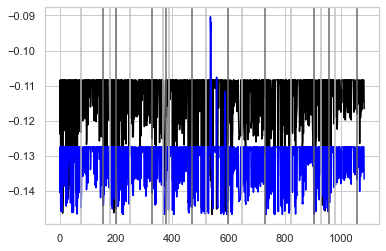

In [39]:
shannon_entropy(prob_wt3)

sns.lineplot(x=range(1084), y = shannon_entropy(prob_wt3), color="black")
sns.lineplot(x=range(1084), y = shannon_entropy(prob_dies61), color="blue")

for border in ARS305_anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in ARS305_anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")

Which each sample having different values for the efficiency E(x), each sample also has very defined minimum and maximum values for the entropy. This doesn't lead to an interpretable value to compare heterogenity of molecules.

In [462]:
# Does smoothing helps against zero-inflation of control?
#pool replicates of the same condition

overlap_plasmid_wt_pooled = np.concatenate((overlap_plasmid_wt3, overlap_plasmid_wt2), axis = 0)
overlap_plasmid_dies6_pooled = np.concatenate((overlap_plasmid_dies6_1, overlap_plasmid_dies6_2), axis = 0)
overlap_plasmid_disw2_pooled = np.concatenate((overlap_plasmid_disw2_1, overlap_plasmid_disw2_2), axis = 0)

overlap_ARS305_wt_pooled = np.concatenate((overlap_ARS305_wt3, overlap_ARS305_wt2), axis = 0)
overlap_ARS305_dies6_pooled = np.concatenate((overlap_ARS305_dies6_1, overlap_ARS305_dies6_2), axis = 0)
overlap_ARS305_disw2_pooled = np.concatenate((overlap_ARS305_disw2_1, overlap_ARS305_disw2_2), axis = 0)
    
    
N=10
def smooth(array):
        return np.convolve(array, np.ones(N)/N, mode = "same")
    
overlap_plasmid_wt_smooth = np.apply_along_axis(smooth, 1, overlap_plasmid_wt_pooled)
overlap_ARS305_wt_smooth = np.apply_along_axis(smooth, 1, overlap_ARS305_wt_pooled)

overlap_plasmid_dies6_smooth = np.apply_along_axis(smooth, 1, overlap_plasmid_dies6_pooled)
overlap_ARS305_dies6_smooth = np.apply_along_axis(smooth, 1, overlap_ARS305_dies6_pooled)

overlap_plasmid_disw2_smooth = np.apply_along_axis(smooth, 1, overlap_plasmid_disw2_pooled)
overlap_ARS305_disw2_smooth = np.apply_along_axis(smooth, 1, overlap_ARS305_disw2_pooled)

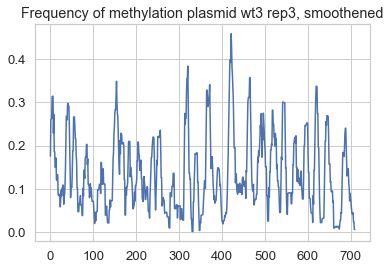

Text(0.5, 0, 'frequency')

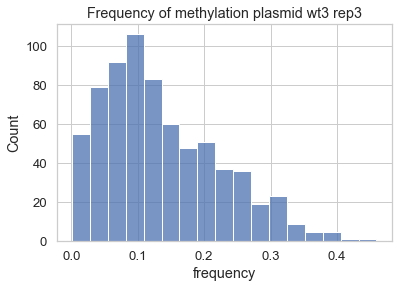

In [463]:
sns.lineplot(x = range(710), y = overlap_plasmid_wt_smooth.mean(axis=0))
plt.title("Frequency of methylation plasmid wt3 rep3, smoothened")
plt.show()

sns.histplot(overlap_plasmid_wt_smooth.mean(axis=0))
plt.title("Frequency of methylation plasmid wt3 rep3")
plt.xlabel("frequency")

In [464]:
#define the mean methylation per position of the plasmid control as the efficiency of methylation per base E(x)
#then, the probabilitity P of a genomic position x being nucleosome-free is:
#P(x) = f(x) + (1-f(x))(1-E(X)) , with f(x) being the frequency of methylation at a genomic position x

prob_wt_smooth =overlap_ARS305_wt_smooth.mean(axis=0) + (1- overlap_ARS305_wt_smooth.mean(axis=0))*(1-overlap_plasmid_wt_smooth.mean(axis=0))

(overlap_ARS305_wt_smooth.mean(axis=0) > overlap_plasmid_wt_smooth.mean(axis=0)).sum()

55

In [465]:
prob_wt_smooth.min(), prob_wt_smooth.max()

(0.5761086956521734, 0.9989846341738379)

Text(0.5, 1.0, 'probability of being nucleosome free, smoothened ARS305 wt rep3')

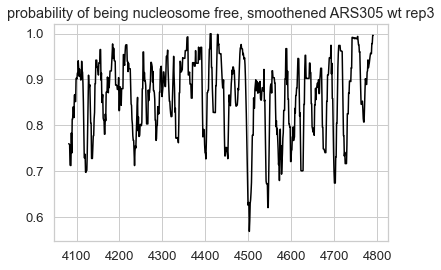

In [466]:
sns.lineplot(x = range(4082,4791), 
             y = prob_wt3_smooth, color = "black")
plt.title("probability of being nucleosome free, smoothened ARS305 wt rep3")

Text(0.5, 1.0, 'Entropy of smoothened ARS305 wt rep3')

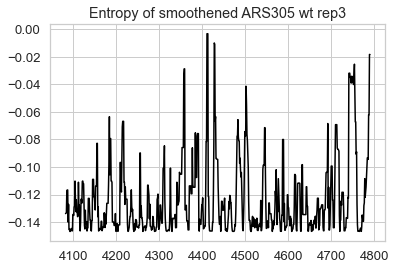

In [467]:
#Entropy for position x is then:
#S = -(P*logP + (1-P)*log(1-P))

def shannon_entropy(P):
    return -(P*np.log(P) - (1-P)*np.log(1-P))

shannon_entropy(prob_wt3_smooth)

sns.lineplot(x = range(4082,4791), 
             y = shannon_entropy(prob_wt3_smooth), color = "black")
plt.title("Entropy of smoothened ARS305 wt rep3")

In [468]:
def calculate_entropy(sample, control):        
    P = sample.mean(axis=0) + (1- sample.mean(axis=0))*(1-control.mean(axis=0))
    Entropy = -(P*np.log(P) - (1-P)*np.log(1-P))
    return Entropy

entropy_ARS305_wt = calculate_entropy(overlap_ARS305_wt_smooth, overlap_plasmid_wt_smooth)
entropy_ARS305_dies6 = calculate_entropy(overlap_ARS305_dies6_smooth, overlap_plasmid_dies6_smooth)
entropy_ARS305_disw2 = calculate_entropy(overlap_ARS305_disw2_smooth, overlap_plasmid_disw2_smooth)

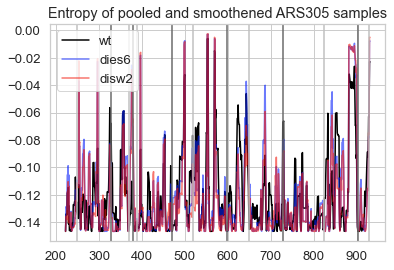

In [469]:
sns.lineplot(x = range(222,932), 
             y = entropy_ARS305_wt, color = "black", label ="wt")
sns.lineplot(x = range(222,932), 
             y = entropy_ARS305_dies6, color = "#0a22fa", alpha = 0.6, label = "dies6")
sns.lineplot(x = range(222,932), 
             y = entropy_ARS305_disw2, color = "#f2180c", alpha = 0.6, label = "disw2")
plt.title("Entropy of pooled and smoothened ARS305 samples")

for border in ARS305_anno.loc[:, "pos_start"]:
    if 222 < border < 935:
        plt.axvline(border, color = "silver")
for border in ARS305_anno.loc[:, "pos_stop"]:
    if 222 < border < 935:
        plt.axvline(border, color = "dimgray")

In [490]:
segments = ARS305_anno.drop(columns = "position")
segments.drop(index = ["+2ns", "+2L", "+3ns"], inplace =True)

#list comprehension to catch the sum of entropy per annotated feature:
array_list = [entropy_ARS305_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]].mean(axis=0) for 
 index in segments.index]

segments["wt"] = pd.Series(array_list, index = segments.index)

array_list = [entropy_ARS305_dies6[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]].mean(axis=0) for 
 index in segments.index]

segments["dies6"] = pd.Series(array_list, index = segments.index)

array_list = [entropy_ARS305_disw2[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]].mean(axis=0) for 
 index in segments.index]

segments["disw2"] = pd.Series(array_list, index = segments.index)

In [492]:
segments["feature"] = segments.index
plot_data = segments.melt(id_vars = "feature", value_vars= ["wt", "dies6", "disw2"], var_name= "sample",
                         value_name = "entropy")


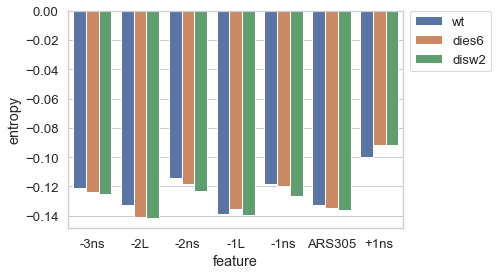

In [493]:
sns.barplot(data=plot_data, x = "feature", y = "entropy", hue = "sample")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

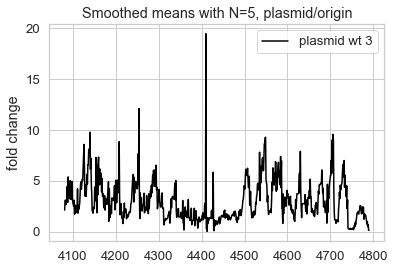

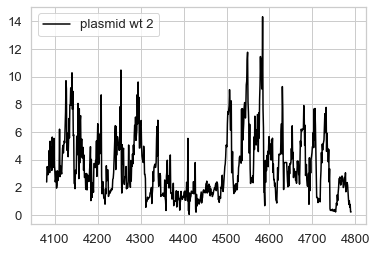

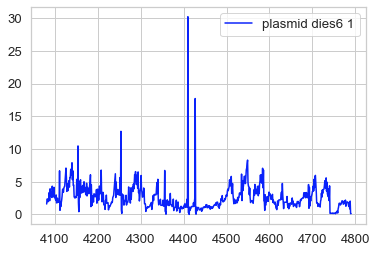

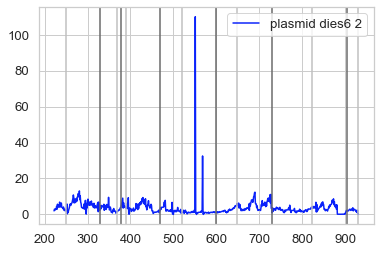

In [494]:
N=10

sns.lineplot(x = range(4081,4791), 
             y = np.convolve(overlap_plasmid_wt3.mean(axis=0), np.ones(N)/N, mode ="same")/np.convolve(
    overlap_ARS305_wt3.mean(axis=0), np.ones(N)/N, mode ="same"), 
             color = "black", label = "plasmid wt 3")
plt.ylabel("fold change")
plt.title("Smoothed means with N=5, plasmid/origin")
plt.show()

sns.lineplot(x = range(4081,4791), 
             y = np.convolve(overlap_plasmid_wt2.mean(axis=0), np.ones(N)/N, mode ="same")/np.convolve(
    overlap_ARS305_wt2.mean(axis=0), np.ones(N)/N, mode ="same"), 
             color = "black", label = "plasmid wt 2")
plt.show()

sns.lineplot(x = range(4081,4791), 
             y = np.convolve(overlap_plasmid_dies6_1.mean(axis=0), np.ones(N)/N, mode ="same")/np.convolve(
    overlap_ARS305_dies6_1.mean(axis=0), np.ones(N)/N, mode ="same"), 
             color = "#0a22fa", label = "plasmid dies6 1")
plt.show()

sns.lineplot(x = range(222,932), 
             y = np.convolve(overlap_plasmid_dies6_2.mean(axis=0), np.ones(N)/N, mode ="same")/np.convolve(
    overlap_ARS305_dies6_2.mean(axis=0), np.ones(N)/N, mode ="same"), 
             color = "#0a22fa", label = "plasmid dies6 2")

for border in ARS305_anno.loc[:, "pos_start"]:
    if 222 < border < 935:
        plt.axvline(border, color = "silver")
for border in ARS305_anno.loc[:, "pos_stop"]:
    if 222 < border < 935:
        plt.axvline(border, color = "dimgray")
plt.show()

## How sparse can we expect the signal to be in the annotated features?

In [519]:
ARS305_anno

seq_char = ARS305_anno.drop(columns = "position")

array_list = [seq[seq_char.loc[index, "pos_start"]:seq_char.loc[index, "pos_stop"]] for 
 index in seq_char.index]

seq_char["sequence"] = pd.Series(array_list, index = seq_char.index)

seq_char["a_percent"] = [row.count("a")/len(row)*100 for row in seq_char["sequence"]]
seq_char["t_percent"] = [row.count("t")/len(row)*100 for row in seq_char["sequence"]]
seq_char["cg_percent"] = [row.count("cg")/len(row)*100 for row in seq_char["sequence"]]
seq_char["gc_percent"] = [row.count("gc")/len(row)*100 for row in seq_char["sequence"]]
seq_char["gc_content"] = [(row.count("c")+row.count("g"))/len(row)*100 for row in seq_char["sequence"]]
seq_char.drop(columns = "sequence", inplace=True)

In [520]:
seq_char

,pos_start,pos_stop,length,a_percent,t_percent,cg_percent,gc_percent,gc_content
0,,,,,,,,
-3ns,74,154,80,21.25,33.750000,2.500000,2.500000,45.000000
-2L,179,199,20,30.00,25.000000,0.000000,0.000000,45.000000
-2ns,249,329,80,26.25,31.250000,1.250000,5.000000,42.500000
-1L,369,379,10,20.00,50.000000,0.000000,0.000000,30.000000
-1ns,389,469,80,31.25,35.000000,3.750000,1.250000,33.750000
ARS305,519,599,80,17.50,20.000000,6.250000,8.750000,62.500000
+1ns,649,729,80,31.25,26.250000,3.750000,6.250000,42.500000
+2ns,824,904,80,11.25,22.500000,15.000000,15.000000,66.250000
+2L,929,959,30,30.00,23.333333,6.666667,6.666667,46.666667
